In [ ]:
# %load transfermatrix_varyThickness.py
#!/usr/bin/python

#	'Copyright' 2012 Kamil Mielczarek (kamil.m@utdallas.edu), University of Texas at Dallas
#	Modifications:
#		10/2012 - Matlab code was ported to python, which is free and readily accessible to all :)
#                   3/2015 Improved accuracy of fundamental constants, fix plotting bugs on some platforms
#
#	Installation Notes:
#		Requires use of the 2.x Branch of python and
#		Matplotlib 	: http://matplotlib.org/
#		Scipy		: http://www.scipy.org/
#		Numpy		: http://numpy.scipy.org/
#                  Pylab             : wiki.scipy.org/PyLab
#
#		A free turn-key solution for windows/mac users is available via Enthought in the 'EPD Free'
#		package which is available via:
#		 http://www.enthought.com/products/epd_free.php
#
#		Linux users need to consult their distributions repositories for available packages

# Original MATLAB CODE WAS :
# Copyright 2010 George F. Burkhard, Eric T. Hoke, Stanford University

#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <http://www.gnu.org/licenses/>.

# This program calculates the calculated short circuit current (assuming an
# internal quantum efficiency of 100%) for a device where the thickness
# of one of the layers is varied. The program uses the transfer matrix
# method.

# The procedure was adapted from J. Appl. Phys Vol 86, No. 1 (1999) p.487
# and JAP 93 No. 7 p. 3693.
# George Burkhard and Eric Hoke February 5, 2010

In [1]:
# Build up the device, light enters from left to right, the layer names
# correspond to the csv filenames in the 'matDir' ignoring the material prefix.
# example : you have a material file named 'nk_P3HT.csv' the layer name would be 'P3HT'
# Layer thicknesses are in nm.
layers 			= ['Air', 'ITO' , 'SnOx', 'MAPbI3' , 'Spiro', 'ITO']
thicknesses		= [0, 150 , 25 , 600 , 250 , 150]

activeLayer		= 3		# indexing starts from 0
layerVaried		= 4		# indexing starts from 0

varyStart		= 90	# starting thickness of the layer to be varied (nm)
varyFinish		= 300	# final thickness of the layer to be varied (nm)
varyStep		= 5		# thickness increments (nm)

lambda_start	= 300	# build a wavelength range to calculate over, starting wavelength (nm)
lambda_stop		= 1200	# final wavelength (nm)
lambda_step		= 5		# wavelength step size

x_step=5.0 # grid spacing of device cross section simulation in nm 
# this is where the n/k optical constants for each material are stored.
# file format is : CSV (comma separated values)
# each materials file is prefixed with 'nk_' and the first 'matHeader' number of lines are skipped.
matDir			= 'matdata'	# materials data
matPrefix		= 'nk_'		# materials data prefix
matHeader		= 1				# number of lines in header

In [2]:
### PROGRAM BEGINS ###
import pylab as pl
from scipy.interpolate import interp1d
import math
from math import ceil
from os.path import join,isfile
import numpy as np
import pylab as py
#%pylab inline

# Constants
h 	= 	6.62606957e-34 	# Js Planck's constant
c	= 	2.99792458e8	# m/s speed of light
q	=	1.60217657e-19	#C electric charge

lambdas			= np.arange(lambda_start,lambda_stop+lambda_step,lambda_step,float)
varyThickness	= np.arange(varyStart,varyFinish+varyStep,varyStep,float)

In [3]:
## HELPER FUNCTIONS
def openFile(fname):
	"""
	opens files and returns a list split at each new line
	"""
	fd = []
	if isfile(fname):
		fn = open(fname, 'r')
		fdtmp = fn.read()
		fdtmp = fdtmp.split('\n')
		# clean up line endings
		for f in fdtmp:
			f = f.strip('\n')
			f = f.strip('\r')
			fd.append(f)
		# make so doesn't return empty line at the end
		if len(fd[-1]) == 0:
			fd.pop(-1)
	else:
		print("%s Target is not a readable file" % fname)
	return fd

def get_ntotal(matName,lambdas):
	fname = join(matDir,'%s%s.csv' % (matPrefix,matName))
	fdata = openFile(fname)[matHeader:]
	# get data from the file
	lambList	= []
	nList		= []
	kList		= []
	for l in fdata:
		wl , n , k = l.split(',')
		wl , n , k = float(wl) , float(n) , float(k)
		lambList.append(wl)
		nList.append(n)
		kList.append(k)
	# make interpolation functions
	int_n	= interp1d(lambList,nList)
	int_k	= interp1d(lambList,kList)
	# interpolate data
	kintList	= int_k(lambdas)
	nintList	= int_n(lambdas)
	# make ntotal
	ntotal = []
	for i,n in enumerate(nintList):
		nt = complex(n,kintList[i])
		ntotal.append(nt)
	return ntotal

def I_mat(n1,n2):
	# transfer matrix at an interface
	r = (n1-n2)/(n1+n2)
	t = (2*n1)/(n1+n2)
	ret = np.array([[1,r],[r,1]],dtype=complex)
	ret = ret / t
	return ret

def L_mat(n,d,l):
	# propagation matrix
	# n = complex dielectric constant
	# d = thickness
	# l = wavelength
	xi = (2*np.pi*d*n)/l
	L = np.array( [ [ np.exp(complex(0,-1.0*xi)),0] , [0,np.exp(complex(0,xi))] ] )
	return L

In [54]:
## / HELPER FUNCTIONS

# load AM1.5G Spectrum
am15_file = join(matDir,'AM15G.csv')
am15_data = openFile(am15_file)[1:]
am15_xData = []
am15_yData = []
for l in am15_data:
	x,y = l.split(',')
	x,y = float(x),float(y)
	am15_xData.append(x)
	am15_yData.append(y)
am15_interp = interp1d(am15_xData,am15_yData,'linear')
am15_int_y  = am15_interp(lambdas)

# initialize an array
n = np.zeros((len(layers),len(lambdas)),dtype=complex)

# load index of refraction for each material in the stack
for i,l in enumerate(layers):
	ni = np.array(get_ntotal(l,lambdas))
	n[i,:] = ni

# calculate incoherent power transmission through substrate

T_glass = abs((4.0*1.0*n[0,:])/((1+n[0,:])**2))
R_glass = abs((1-n[0,:])/(1+n[0,:]))**2

In [55]:
# len(layerVaried)

/Users/shreya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: ComplexWarning: Casting complex values to real discards the imaginary part


19.754998706832218 110.0 4


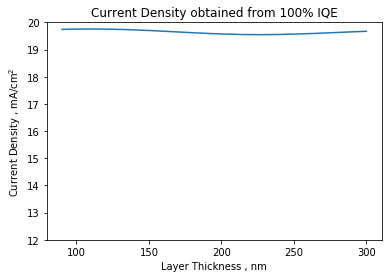

In [56]:
# # loop for varying all 3 thicknesses 

# jsc_max = 0
# op_thic 
# lay 

# for dum in range(len(layerVaried)):
# 	beg = varyStart[dum]
# 	end = varyFinish[dum] + varyStep
t 		= thicknesses
t[0] 	= 0
Jsc		= 0*varyThickness

for thickInd,thick in enumerate(varyThickness):
	t[layerVaried] = varyThickness[thickInd]
	# calculate transfer marices, and field at each wavelength and position
	t_cumsum	= np.cumsum(t)
	x_pos		= np.arange((x_step/2.0),sum(t),x_step)
	# get x_mat
	comp1	= np.kron(np.ones( (len(t),1) ),x_pos)
	comp2	= np.transpose(np.kron(np.ones( (len(x_pos),1) ),t_cumsum))
	x_mat 	= sum(comp1>comp2,0) 	# might need to get changed to better match python indices
	#
	R		= lambdas*0.0
	T		= lambdas*0.0
	E		= np.zeros( (len(x_pos),len(lambdas)),dtype=complex )
	# start looping
	for ind,l in enumerate(lambdas):
		# calculate the transfer matrices for incoherent reflection/transmission at the first interface
		S = I_mat(n[0,ind],n[1,ind])
		for matind in np.arange(1,len(t)-1):
			mL = L_mat( n[matind,ind] , t[matind] , lambdas[ind] )
			mI = I_mat( n[matind,ind] , n[matind+1,ind])
			S  = np.asarray(np.mat(S)*np.mat(mL)*np.mat(mI))
		R[ind] = abs(S[1,0]/S[0,0])**2
		T[ind] = abs((2/(1+n[0,ind])))/np.sqrt(1-R_glass[ind]*R[ind])
		# good up to here
		# calculate all other transfer matrices
		for material in np.arange(1,len(t)):
			xi = 2*np.pi*n[material,ind]/lambdas[ind]
			dj = t[material]
			x_indices	= np.nonzero(x_mat == material)
			x			= x_pos[x_indices]-t_cumsum[material-1]
			# Calculate S_Prime
			S_prime		= I_mat(n[0,ind],n[1,ind])
			for matind in np.arange(2,material+1):
				mL = L_mat( n[matind-1,ind],t[matind-1],lambdas[ind] )
				mI = I_mat( n[matind-1,ind],n[matind,ind] )
				S_prime  = np.asarray( np.mat(S_prime)*np.mat(mL)*np.mat(mI) )
			# Calculate S_dprime (double prime)
			S_dprime	= np.eye(2)
			for matind in np.arange(material,len(t)-1):
				mI	= I_mat(n[matind,ind],n[matind+1,ind])
				mL	= L_mat(n[matind+1,ind],t[matind+1],lambdas[ind])
				S_dprime = np.asarray( np.mat(S_dprime) * np.mat(mI) * np.mat(mL) )
			# Normalized Electric Field Profile
			num = T[ind] * (S_dprime[0,0] * np.exp( complex(0,-1.0)*xi*(dj-x) ) + S_dprime[1,0]*np.exp(complex(0,1)*xi*(dj-x)))
			den = S_prime[0,0]*S_dprime[0,0]*np.exp(complex(0,-1.0)*xi*dj) + S_prime[0,1]*S_dprime[1,0]*np.exp(complex(0,1)*xi*dj)
			E[x_indices,ind] = num / den
            
	#correcting the multiplication error; 0.5% marginal error in calculation
	for onanchk_ind in range(E.shape[0]):
		for nanchk_ind in range(E.shape[1]):
			temp_nanvar = E[onanchk_ind,nanchk_ind]
			if math.isnan(temp_nanvar):
				E[onanchk_ind,nanchk_ind] = E[onanchk_ind,nanchk_ind-1]
  
	# Absorption coefficient in 1/cm
	a = np.zeros( (len(t),len(lambdas)) )
	for matind in np.arange(1,len(t)):
		a[matind,:] = ( 4 * np.pi * np.imag(n[matind,:]) ) / ( lambdas * 1.0e-7 )
	#
	ActivePos = np.nonzero(x_mat == activeLayer)
	tmp1	= (a[activeLayer,:]*np.real(n[activeLayer,:])*am15_int_y)
	Q	 	= np.tile(tmp1,(np.size(ActivePos),1))*(abs(E[ActivePos,:])**2)
	# Exciton generatoion are
	Gxl		= (Q*1.0e-3)*np.tile( (lambdas*1.0e-9) , (np.size(ActivePos),1))/(h*c)
	if len(lambdas) == 1:
		lambda_step = 1
	else:
		lambda_step = (sorted(lambdas)[-1] - sorted(lambdas)[0])/(len(lambdas) - 1)
	Gx		= np.sum(Gxl,2)*lambda_step
	# calculate Jsc
	Jsc[thickInd] = np.sum(Gx)*x_step*1.0e-7*q*1.0e3
# 		if (Jsc[thickInd]> jsc_max):
# 			jsc_max = Jsc[thickInd]
# 			lay = dum
# 			op_thic = thickInd            
            
        
# 		max_jsc[dum] = np.max(Jsc)

# 	print("Layer : ", lay)
# 	print("Optimal thickness : ", op_thic)
# 	print("Jsc max : ", jsc_max)

	# Plotting Portion
	fig4 = pl.figure(4)
	fig4.clf()
	ax4 = fig4.add_subplot(111)
	ax4.set_ylim(12,14)
	ax4.set_title('Current Density obtained from 100% IQE')
	ax4.set_ylabel('Current Density , mA/cm$^2$')
	ax4.set_xlabel('Layer Thickness , nm')
	ax4.set_ylim(top=ceil(sorted(Jsc)[-1]))
	ax4.plot(varyThickness,Jsc)

p1 = np.argmax(Jsc)

print(np.max(Jsc), varyThickness[p1], p1)